## Загрузка библиотек

In [124]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [125]:
def generate(n):
    m = 2

    w_true = np.random.standard_normal(m)

    X = np.random.uniform(-5, 5, (n, m))
    X *= (np.arange(m) * 2 + 1)[np.newaxis, :]

    y = X.dot(w_true) + np.random.normal(0, 1, (n))

    return X,y

[Text(0.5, 0, 'X[0]'), Text(0, 0.5, 'X[1]')]

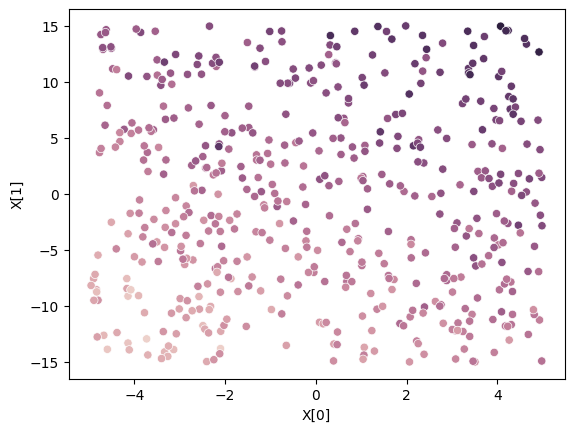

In [184]:
X,y = generate(500)
g = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
g.legend_.remove()
g.set(xlabel="X[0]", ylabel="X[1]")

In [116]:
def generate_batch(X, y, batch_size):
    """ Генератор для получения батча из данных """
    for i in range(0, len(X), batch_size):
        yield X[i : i + batch_size], y[i : i + batch_size]

In [118]:
def plot_weight_levels(X, y, w_history: np.ndarray):
    w1_vals = np.linspace(min(w_history[:, 0]) - 1, max(w_history[:, 0]) + 1, 100)
    w2_vals = np.linspace(min(w_history[:, 1]) - 1, max(w_history[:, 1]) + 1, 100)
    
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    J_vals = np.zeros_like(W1)

    for i in range(len(w1_vals)):
        for j in range(len(w2_vals)):
            w_tmp = np.array([W1[i, j], W2[i, j]])
            J_vals[i, j] = np.mean((X.dot(w_tmp) - y) ** 2) / 2

    plt.figure(figsize=(12, 8))
    plt.contour(W1, W2, J_vals, levels=30, cmap='viridis')

    # w_history = w_history[w_history[:, 0].argsort()[::-1]]
    print(w_history[-1])
    plt.plot(w_history[1:, 0], w_history[1:, 1], marker='.', linestyle='-', color='red', label='Gradient Descent Trajectory')
    plt.plot(w_history[-1][0], w_history[-1][1], '*', ms=10, color='black', label='Final Point')

    plt.title('Weight Levels and Gradient Descent Trajectory')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.legend()
    plt.show()

## Реализация метода инерции

In [117]:
def sgd_with_momentum(
    epochs: int, 
    batch_size: int, 
    alpha: float,
    beta : float,
    X: np.ndarray, 
    y: np.ndarray, 
    w = None,
    max_iters=1000
):
    
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)
    
    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    n_iter = 0
    h = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch

            grad = 2 * X_batch.T.dot(err) / n
            h = beta*h + alpha*grad
            w_cur = w_cur - h
        
            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)


    return w, np.array(w_history), np.array(err_history)


[0.4344324  0.24674851]


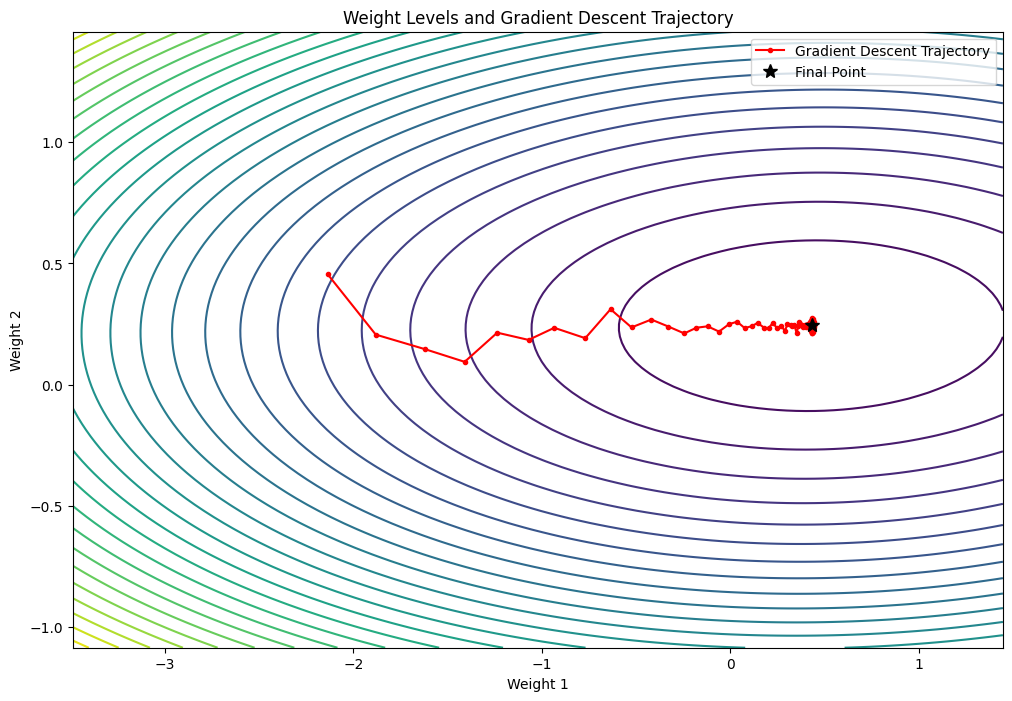

In [185]:
w, w_history, _ = sgd_with_momentum(epochs=500000,batch_size=100, alpha=0.03, beta=1e-2, X=X, y=y)

plot_weight_levels(X, y, w_history)

## Реализация RMSprop

In [120]:
def RMSprop(
    epochs: int, 
    batch_size: int, 
    alpha: float,
    beta : float,
    X: np.ndarray, 
    y: np.ndarray, 
    w = None,
    max_iters=10000,
    eps = 1e-8
):
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    n_iter = 0
    G = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) # случайно перемешиваем выборку
        batch_generator = generate_batch(X[p], y[p], batch_size)  # инициализируем генератор

        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch

            grad = 2 * X_batch.T.dot(err) / n
            G = beta*G + (1-beta)*((grad)**2)
            w_cur = w_cur - alpha * grad / (G+eps)**0.5
            
            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)


    return w, np.array(w_history), np.array(err_history)
    

[0.43182626 0.2433842 ]


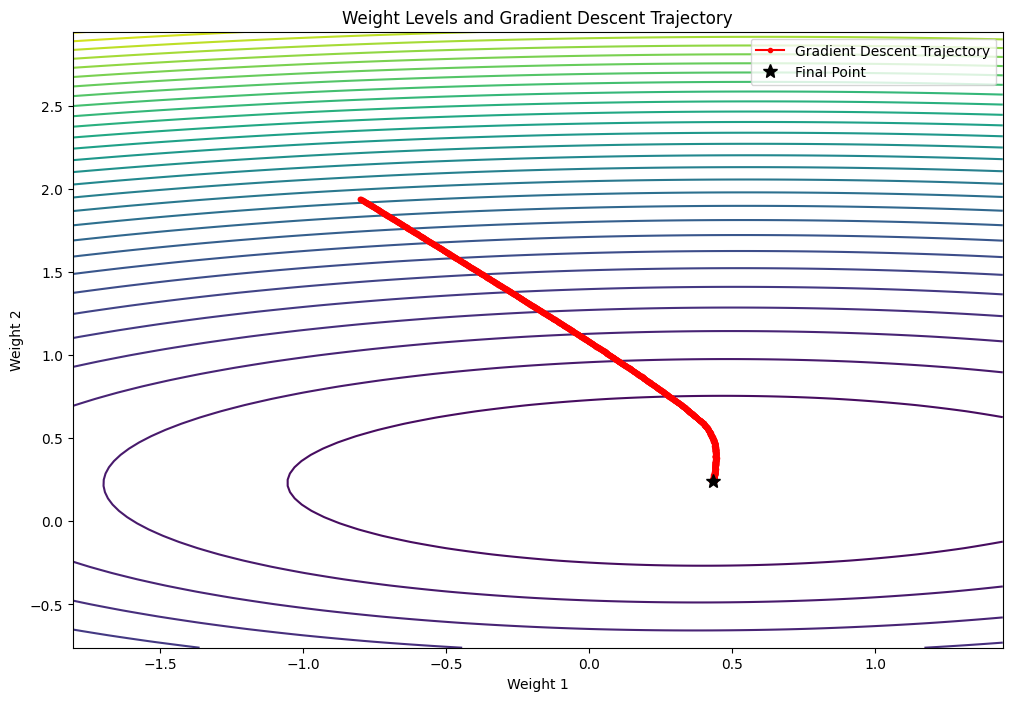

In [186]:
w, w_history, _ = RMSprop(epochs=5000,batch_size=100, alpha=1e-3, beta=0.9, X=X, y=y, max_iters=1e8)

plot_weight_levels(X, y, w_history)

## Реализация Adam

In [122]:
def Adam(
    epochs: int, 
    batch_size: int, 
    alpha: float,
    beta1 : float,
    beta2: float,
    X: np.ndarray, 
    y: np.ndarray, 
    w = None,
    max_iters=100000,
    eps = 1e-8
):
    n, m = X.shape[0], X.shape[1]

    if w is None:
        w = np.random.standard_normal(m)

    w_cur = w.copy()
    w_history = [w_cur]
    err_history = []
    n_iter = 0
    G = 0
    h = 0
    for _ in range(epochs):
        p = np.random.permutation(len(X)) 
        batch_generator = generate_batch(X[p], y[p], batch_size)

        for X_batch, y_batch in batch_generator:
            y_pred = X_batch.dot(w_cur)
            err = y_pred - y_batch

            grad = 2 * X_batch.T.dot(err) / n
            h = beta1*h + (1-beta1)*grad

            G = beta2*G + (1-beta2)*((grad)**2)
            w_cur = w_cur - alpha * h / ((G)**0.5 + eps)
            
            w_history.append(w_cur.copy())
            err_history.append(err.mean())
            
            n_iter += 1
            if n_iter == max_iters:
                 return w, np.array(w_history), np.array(err_history)


    return w, np.array(w_history), np.array(err_history)

[0.43217904 0.24322543]


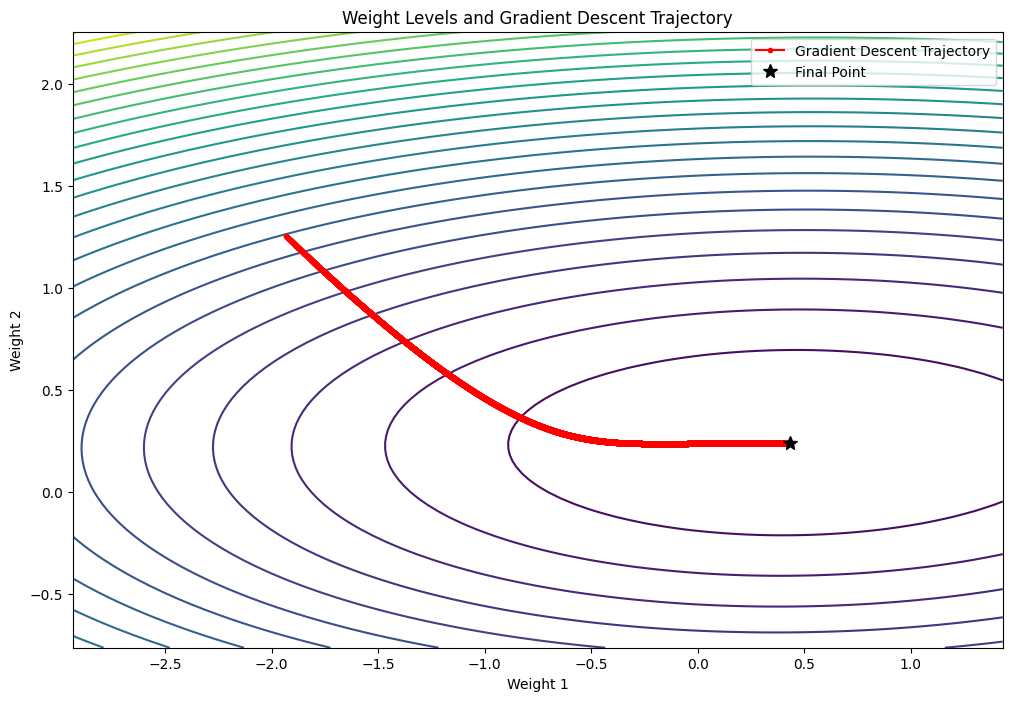

In [187]:
w, w_history, adam_err = Adam(epochs=5000,batch_size=100, alpha=3e-4, beta1=0.9, beta2=0.999, X=X, y=y, max_iters=1e8)

plot_weight_levels(X, y, w_history)

Посмотрим результаты на другом наборе данных

In [158]:
X, y = generate(5000)

[-0.52056979  0.171232  ]


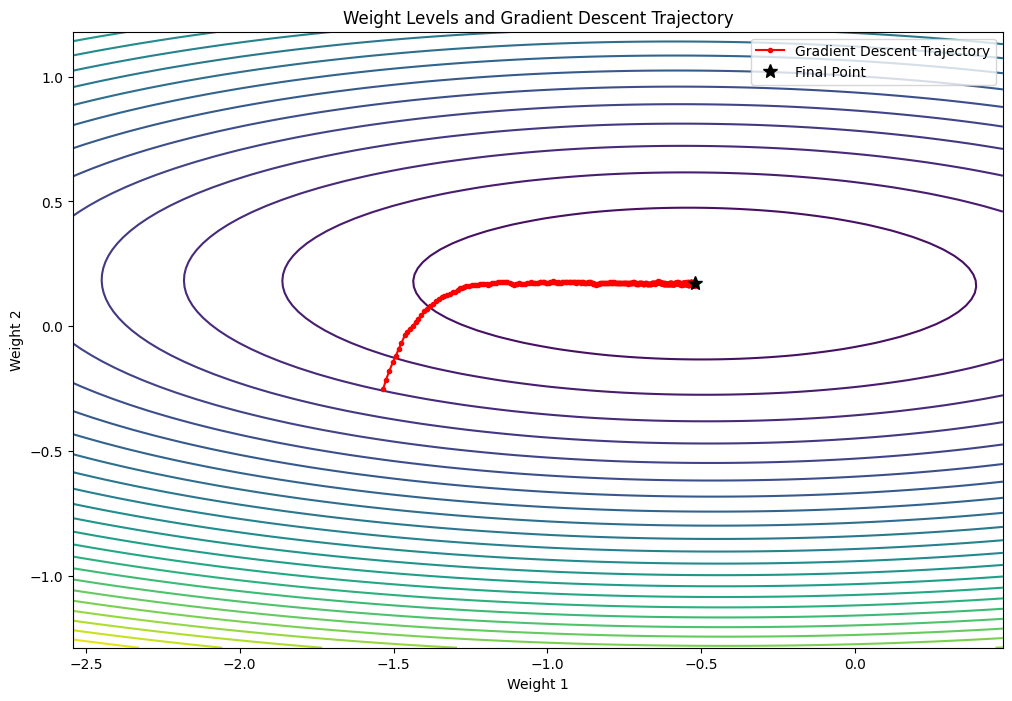

In [172]:
w, w_history, momentum_err = sgd_with_momentum(epochs=50,batch_size=100, alpha=0.03, beta=1e-2, X=X, y=y, max_iters=1e3)

plot_weight_levels(X, y, w_history)

[-0.52338809  0.17072375]


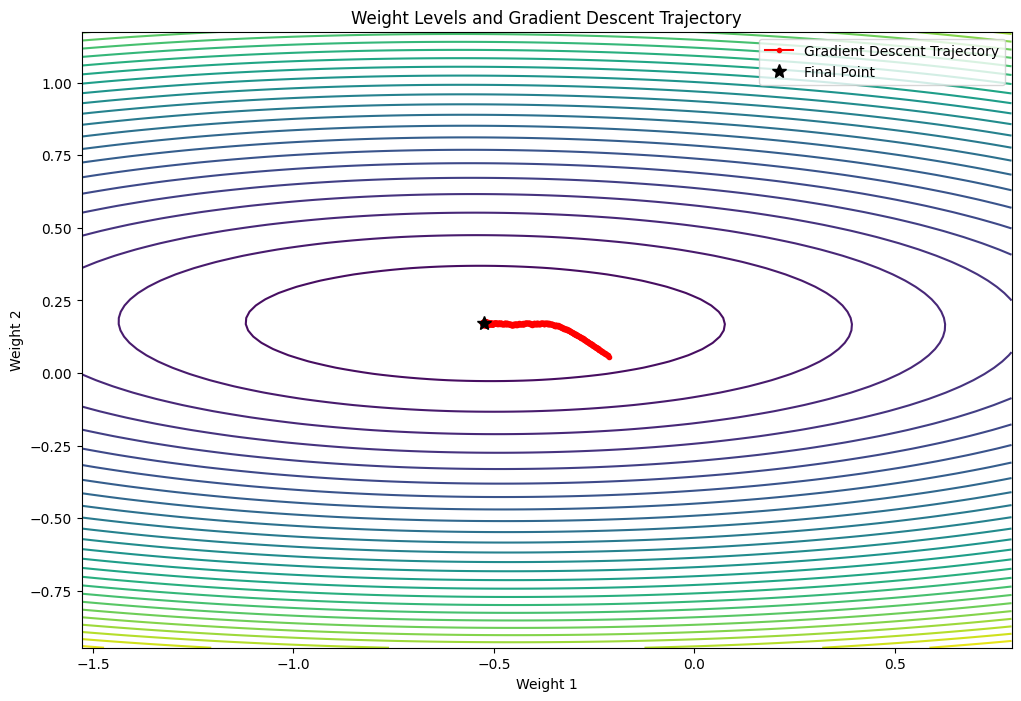

In [175]:
w, w_history, rms_error = RMSprop(epochs=50,batch_size=100, alpha=1e-3, beta=0.9, X=X, y=y, max_iters=1e3)

plot_weight_levels(X, y, w_history)

[-0.49254677  0.17268953]


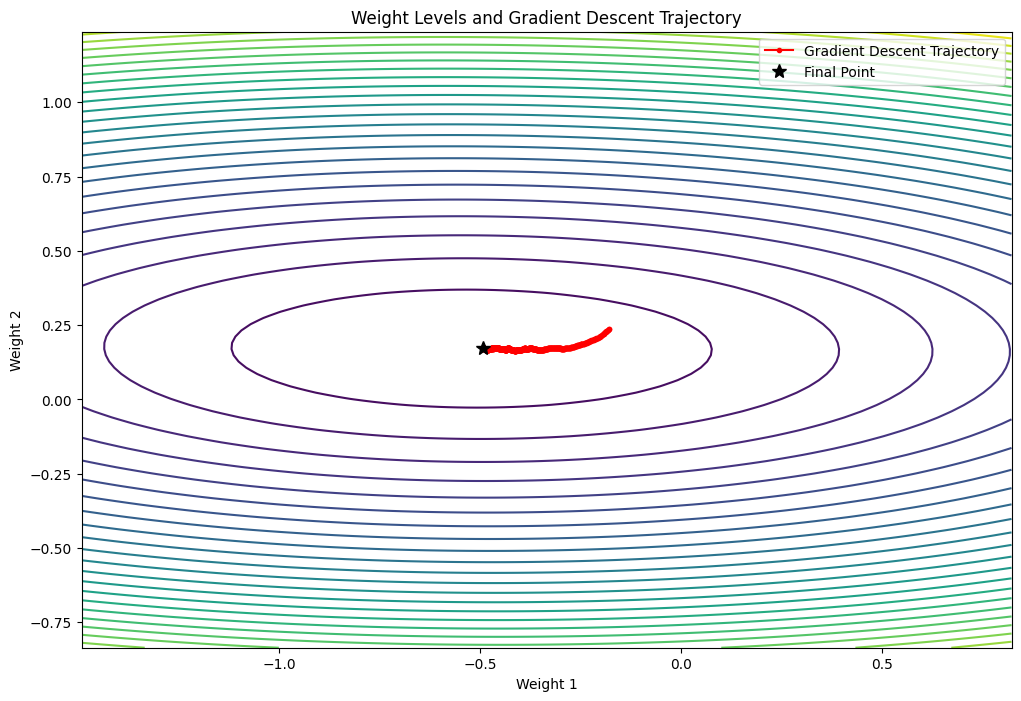

In [181]:
w, w_history, adam_err = Adam(epochs=50,batch_size=10, alpha=3e-4, beta1=0.9, beta2=0.999, X=X, y=y, max_iters=1e3)

plot_weight_levels(X, y, w_history)

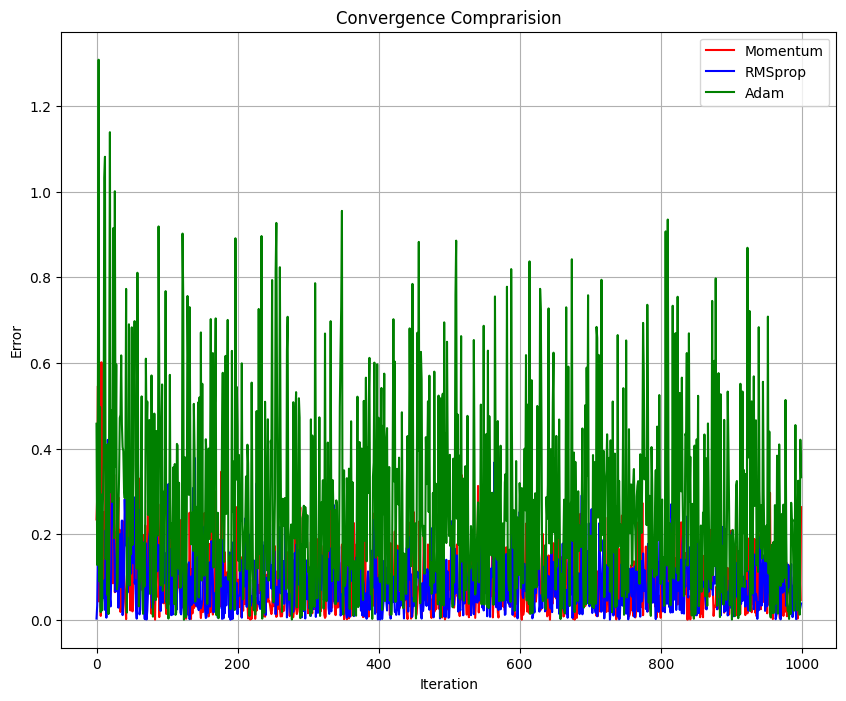

In [182]:
plt.figure(figsize=(10,8))

plt.plot(abs(momentum_err), label='Momentum', color='r')
plt.plot(abs(rms_error), label='RMSprop', color='b')
plt.plot(abs(adam_err), label='Adam', color='g')

plt.title("Convergence Comprarision")

plt.xlabel("Iteration")
plt.ylabel("Error")



plt.legend()
plt.grid(True)
plt.show();



Резюмируем:   
Не подбирая параметры для каждого оптимизатора, можно заметить, что с лучшими методами оказались Adam и RMSprop. Momentum на 1000 итерациях не справился с оптимизацией.